# Experiments with data structures and sparsity

## Comparison between integerised and weights matrices

In [1]:
import glob
import numpy as np
import os
import pandas as pd
from scipy.sparse import coo_matrix
import scipy

In [2]:
# read in an integerised matrix
path2csv = "../persistant_data/od_matrices_OLD_VERSION/csvs/F_16to19_OD_matrix_EW.csv"
list_of_files = glob.glob(path2csv)

for i, fi in enumerate(list_of_files):
    print(f"Processing: {fi}")
    od_int = pd.read_csv(fi).values
    od_val_int = od_int[:, 1:]
    od_val_int = od_val_int.astype(np.float)
    #od_val_int_sparse = coo_matrix(od_int)
    #scipy.sparse.save_npz(fi.split(".csv")[0] + ".npz", od_val_sparse)

Processing: ../persistant_data/od_matrices_OLD_VERSION/csvs/F_16to19_OD_matrix_EW.csv


In [3]:
# read in a weight matrix
path2csv = "../persistant_data/od_matrices/F_16to19_prob_matrix_EW.csv"
list_of_files = glob.glob(path2csv)

for i, fi in enumerate(list_of_files):
    print(f"Processing: {fi}")
    od_weights = pd.read_csv(fi).values
    od_val_w = od_weights[:, 1:]
    od_val_w = od_val_w.astype(np.float)
    #od_val_sparse = coo_matrix(od_val)
    #scipy.sparse.save_npz(fi.split(".csv")[0] + ".npz", od_val_sparse)

Processing: ../persistant_data/od_matrices/F_16to19_prob_matrix_EW.csv


In [4]:
# Make the weight matrix sparse

# threshold
# e.g., 0.6 means all the values that contribute to 60% of the total sum (row-wise) will be set to 0
row_threshold = 0.5

for i in range(od_val_w.shape[0]):
    row_sorted = np.sort(od_val_w[i, :])
    row_cumsum = np.cumsum(row_sorted)
    row_cumsum_norm = row_cumsum / row_cumsum[-1]
    filt_val = row_sorted[np.argmax(row_cumsum_norm > row_threshold)]
    od_val_w[i, od_val_w[i, :] < filt_val] = 0

In [5]:
# test size of the sparse matrix
od_val_sparse = coo_matrix(od_val_w)
scipy.sparse.save_npz("./test.npz", od_val_sparse)
!du -sh ./test.npz

1.1M	./test.npz


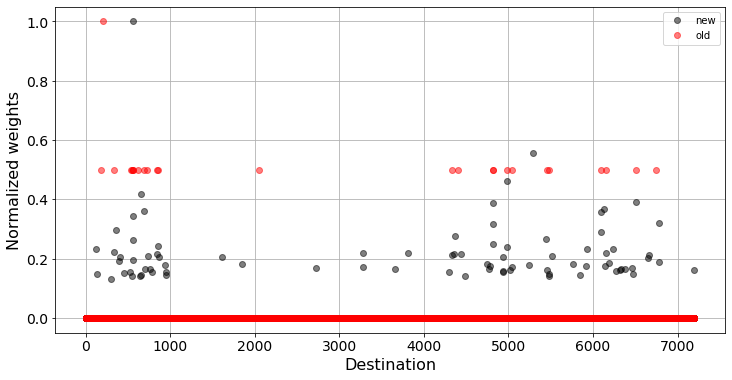

In [6]:
# Compare sparse weight matrix with integerised matrix
id2plot = 0

import matplotlib.pyplot as plt
plt.figure(figsize=(12, 6))

plt.plot(od_val_w[id2plot, :]/np.max(od_val_w[id2plot, :]), 
         c="k", alpha=0.5, label="new", ls=' ', marker="o")
plt.plot(od_val_int[id2plot, :]/np.max(od_val_int[id2plot, :]), 
         c="r", alpha=0.5, label="old", ls=' ', marker="o")

plt.xticks(size=14)
plt.yticks(size=14)
plt.xlabel("Destination", size=16)
plt.ylabel("Normalized weights", size=16)
plt.legend()
plt.grid()

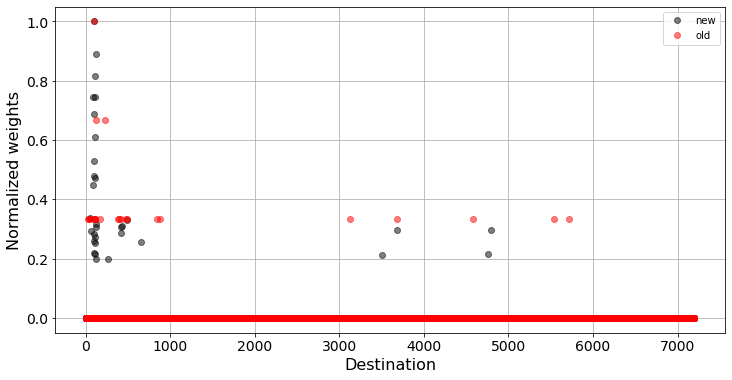

In [7]:
# Compare sparse weight matrix with integerised matrix
id2plot = 100

import matplotlib.pyplot as plt
plt.figure(figsize=(12, 6))

plt.plot(od_val_w[id2plot, :]/np.max(od_val_w[id2plot, :]), 
         c="k", alpha=0.5, label="new", ls=' ', marker="o")
plt.plot(od_val_int[id2plot, :]/np.max(od_val_int[id2plot, :]), 
         c="r", alpha=0.5, label="old", ls=' ', marker="o")

plt.xticks(size=14)
plt.yticks(size=14)
plt.xlabel("Destination", size=16)
plt.ylabel("Normalized weights", size=16)
plt.legend()
plt.grid()

# ---- PLAYGROUND

## Experiment with data structures

In [8]:
import numpy as np
import os
import pandas as pd

In [9]:
num_dests = 1000
num_ages = 5
num_genders = 2
num_eth = 10

In [10]:
# if os.path.isfile("./store.h5"):
#     os.remove("./store.h5")
# store = pd.HDFStore("store.h5", "w")

In [11]:
df1 = np.random.randint(0,100,
                          size=(num_dests*num_genders*num_ages, 
                                num_dests))

In [12]:
df1 = pd.DataFrame(df1)

In [13]:
df1.shape

(10000, 1000)

In [14]:
# store.append("df1", df1)

In [15]:
# store.select("df1", np.random.randint(0, num_dests*num_genders*num_ages, 10000))

In [16]:
%%timeit
df1[df1.index.isin(np.random.randint(0, num_dests*num_genders*num_ages, 10000))]

16.6 ms ± 904 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [17]:
pop = pd.read_pickle("./example_pop_internal_migration.pkl")

In [18]:
pop_migrated = pop[pop["internal_outmigration"] == "Yes"]

In [19]:
pop_migrated.head()

,tracked,internal_outmigration,last_outmigration_time,ethnicity,sex,entrance_time,exit_time,alive,age,location
12,True,Yes,2011-09-08,WBI,1,2010-12-22,NaT,alive,2.041096,E09000002
30,True,Yes,2011-01-11,WBI,1,2010-12-22,NaT,alive,3.041096,E09000002
41,True,Yes,2011-10-28,WBI,1,2010-12-22,NaT,alive,3.041096,E09000002
54,True,Yes,2011-03-22,WBI,1,2010-12-22,NaT,alive,4.041096,E09000002
83,True,Yes,2011-11-27,WBI,1,2010-12-22,NaT,alive,5.041096,E09000002


In [21]:
cut_bins = [0, 15, 49, 64, 74, 100]
cut_labels = ["01", "02", "03", "04", "05"]
pop_migrated.loc[:, "age_bucket"] = pd.cut(pop_migrated['age'], bins=cut_bins, labels=cut_labels)

In [22]:
pop_migrated["location"].unique()

array(['E09000002'], dtype=object)

In [23]:
loc_codes = {"E09000002": "00001"}

In [25]:
pop_migrated["migration_ids"] = pop_migrated["sex"].astype(str) + \
                                pop_migrated["age_bucket"].astype(str) + \
                                pop_migrated["location"].replace(loc_codes)

/Users/khosseini/anaconda3/envs/vwm_py36/lib/python3.6/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


In [26]:
list(pop_migrated["migration_ids"].unique())

['10100001',
 '10200001',
 '10300001',
 '10400001',
 '10500001',
 '20100001',
 '20200001',
 '20300001',
 '20400001',
 '20500001']

In [27]:
all_ids = list(pop_migrated["migration_ids"].unique())

## h5py format

In [ ]:
import h5py
import numpy as np
import os
import pandas as pd

In [ ]:
f = h5py.File("test.hdf5", "w")

In [ ]:
dset = f.create_dataset("test1", 
                        (2000000000, 1000000), 
                        maxshape=(None, None))

In [ ]:
aa = np.random.randint(0, 2000000000, size=10000)

In [ ]:
dset2 = f.create_dataset("test2", 
                        (num_genders*num_ages*num_eth*num_dests, 2), 
                        maxshape=(None, None),
                        dtype="i", 
                        fillvalue=0
                        )
                        #dtype=([("id", "S10"), ("index", "i8")]))

In [ ]:
dset2[0:1000, 0:1000] = np.array([np.arange(0, 1000), np.arange(0, 1000)]).T